# Homogeneisation - main

L'objectif est de mettre à disposition des chercheurs une interface permettant :
- le calcul de comportements homogénéisés sur des microstructures données à l'aide de différents modèles pré-implémentés, manuellement ou à partir d'un fichier texte,
- de faciliter des études parmaétriques sur ces mêmes modèles et microstructures,
- de déterminer des paramètres idéaux pour atteindre des comportements homogénéisés cibles(TODO),
- de fournir une description des modèles utilisés, de leur forces et de leurs limites.

Ce code contient plusieurs sections. **Lorsque le code est lancé pour la première fois sur un nouveau kernel, les sections suivantes doivent être executées dans l'ordre** :
- Importation des classes et des modules utiles
- Fonctions utiles 

Les sections suivantes sont indépendantes. Si une section est lancée pour la première fois, ses cellules doivent être executées dans l'ordre.

---

## I- Importation des classes et des modules utiles

In [1]:
!pip install ipywidgets # Installation du package permettant la gestion des widgets

     |████████████████████████████████| 121 kB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import ipywidgets as widgets
from IPython.display import display
from classes import *

In [3]:
print("Modèles importés : {}".format(list_models))

Modèles importés : [<class 'classes.Mori_Tanaka'>]


---

## II- Fonctions utiles

In [18]:
parameters_name = {'K': 'Bulk modulus K', 'G': 'Shear modulus G'}
parameters_name_bis = {value: key for (key, value) in parameters_name.items()}

def gen_tab_behavior():
    """
    Routine qui génère un widget de type 'tab' permettant le choix des paramètres associés aux comportements. 
    Chaque onglet généré correspond à un comportement du dictionnaire 'dict_behaviors' implémenté dans 'classes.py'.
    La fonction renvoie :
    - une liste de liste de widgets (list_widgets) contenant autant de listes que d'onglet. Chaque liste contient les widgets générant les paramètres asssociés au comportement 
    de l'onglet correspondant.
    - un widget tab correspondant au résultat final à afficher.    
    """
    behaviors_str = list(dict_behaviors.keys()) # Liste des noms des comportements déjà implémentés, définis dans classes.py
    list_widgets = [] # Liste de liste, chaque liste correspond à un onglet du tab et contient les widgets de cet onglet non formatés
    tab_titles = [] # Nom des onglets, chaque onglet est associé à un type de comportement
    # Construction des widgets associés à chaque onglet
    for behavior_str in behaviors_str:
        widgets_onglet = []
        parameters = dict_behaviors[behavior_str] # Paramètres associés au comportement (exemple : ['K', 'G'] pour Isotropic)
        for parameter in parameters: # TODO : possibilité de choisir E et mu ou lambda et nu pour l'isotrope, avec des widgets accordéons dans le tab
            w = widgets.FloatSlider(value=1, min=0.01, max=1000, step=0.1) # Widget associé au paramètre parameter
            w_label = widgets.Label(value=parameters_name[parameter])
            widgets_onglet.append(widgets.HBox([w_label, w]))
        list_widgets.append(widgets_onglet)
        tab_titles.append(behavior_str)
    # Création du tab
    tab = widgets.Tab()
    tab.children = [widgets.HBox(w) for w in list_widgets]
    for pos, title in enumerate(tab_titles):
        tab.set_title(pos, title)
    return list_widgets, tab

def read_behavior(tab, list_widgets):
    """
    Fonction qui, à partir d'un widget 'tab' comme celui construit par la fonction précédente, renvoie le dictionnaire 'behavior' construit par l'utilisateur.
    """
    behavior_int = tab.selected_index # Onglet ouvert par l'utilisateur
    widgets_parameters = list_widgets[behavior_int] # Widgets des paramètres de l'onglet ouvert
    behavior = {parameters_name_bis[w.children[0].value] : w.children[1].value for w in widgets_parameters}
    return behavior

def str_to_model(model_name):
    """
    Fonction qui renvoie l'instance de classe Model associée au nom de classe model_name (str).
    TODO : formater le nom pour être plus souple (majuscules, etc..)
    """
    for Model in list_models:
        model = Model()
        if model.name == model_name:
            return model
    
def process_parameters(dict_parameters):
    """
    Permet de réaliser la conversion entre les différents sets de pramètres d'isotropie existants (K et G, E et nu, lambda et mu).
    Prend en entrée un dictionniaire de paramètres (exemple : {'K': K_value, 'G': G_value}).
    Renvoie :
    - la valeur de K et G sous la forme d'un dictionnaire de paramètres si les paramètres correspondent à un comportement isotrope,
    - le dictionnaire donné en entrée sinon.
    """
    entry_parameters = list(dict_parameters.keys())
    if entry_parameters == ['E', 'nu']:
        E, nu = dict_parameters['E'], dict_parameters['nu']
        K = E/(3*(1-2*nu))
        G = E/(2*(1+nu))
        result = {'K': K, 'G': G}
    else:
        result = dict_parameters
    return result

---

## III- Calcul de comportement homogénéisé de microstructures
Cette section permet la génération manuelle de microstructure et le calcul de comportement homogénéisé avec les modèles disponibles.

In [7]:
dict_inclusions = {}
# Initialise la liste des inclusions créees. dict_inclusions est sous la forme {nam_inclusion (str): inclusion (Inclusion)}

### Construction d'une inclusion

In [8]:
# Nom de l'inclusion
w_label = widgets.Label(value='Inclusion name')
w_name = widgets.Text(value='inclusion0')
display(w_label, w_name)

# Type d'inclusion
w_label = widgets.Label(value='Inclusion type')
w_type = widgets.Dropdown(options=[('Spheres', 0)], value=0) #TODO : synchroniser avec classes.py à l'aide d'un dict pour ajouter plus facilement des types d'inclusions
w = widgets.VBox([w_label, w_type])
display(w)

# TODO : caractéristiques géométriques (rayon, etc..) selon le type

# Comportement de l'inclusion
caption = widgets.Label(value='Inclusion behavior')
display(caption)
list_widgets, tab = gen_tab_behavior()
display(tab)

# Génération de l'inclusion
button_generate_inclusion = widgets.Button(description="Generate Inclusion")
output = widgets.Output()
display(button_generate_inclusion, output)
def generate_inclusion(b):
    """
    Fonction appelée lors d'un click sur le bouton, génère une inclusion avec les paramètres choisis.
    TODO : modifier le nom de l'inclusion automatiquement
    """
    # Récupération des paramètres choisis
    output.clear_output()
    inclusion_name = w_name.value
    if inclusion_name in list(dict_inclusions.keys()):
        with output:
            print("Name already exists")
    else :
        type_inclusion = w_type.value
        behavior = read_behavior(tab, list_widgets)
        inclusion = Inclusion(type_inclusion, behavior, name=inclusion_name)
        dict_inclusions[inclusion_name] = inclusion
        with output:
            print("Inclusion generated: ", inclusion)
    
button_generate_inclusion.on_click(generate_inclusion)

Label(value='Inclusion name')

Text(value='inclusion0')

Label(value='Inclusion behavior')

Button(description='Generate Inclusion', style=ButtonStyle())

Output()

### Construction d'une microstructure

In [15]:
# Création de la variable contenant la microstructure
microstructure = None # Initialisation

In [16]:
# Fonctions liées aux appuis sur les boutons
def add_inclusion_to_structure(b):
    """
    Fonction appelée lors d'un click sur le bouton "Add inclusion", génère un widget associé à la fraction volumique de l'inclusion et l'ajoute au dictionnaire "widgets_f".
    Crée aussi un bouton permettant la suppression de l'inclusion et l'ajoute au dictionnaire buttons.
    Enfin, affiche la ligne de widgets correspondante.
    """
    out2.clear_output()
    inclusion = w_inclusions.value
    if inclusion in list(widgets_f.keys()):
        with out2:
            print("Already added")
    else:
        w_name = widgets.Label(inclusion.name)
        w_f = widgets.FloatSlider(min=0.01, max=1, step=0.01, description='f')
        w_b = widgets.Button(description="Remove inclusion")
        w_b.on_click(remove_inclusion)
        widgets_f[inclusion] = (w_name, w_f)
        buttons_suppress[w_b] = inclusion
        with out1:
            display(w_name, widgets.HBox([w_f, w_b]))

def add_inclusion_to_list(b):
    """
    Fonction appelée lors d'un clic sur le bouton 'generate inclusion' de la section précédente.
    met à jour le widget permettant le choix des inclusions à ajouter.
    """
    w_inclusions.options = list(dict_inclusions.values())
    
def remove_inclusion(b):
    """
    Fonction appelée lorsqu'un bouton 'Remove inclusion' est appelé. 
    Repère l'inclusion associée au bouton, ferme les widgets associés et supprime l'entrée du dictionnaire widgets_f
    """
    out2.clear_output()
    inclusion = buttons_suppress[b]
    w_name, w_f = widgets_f[inclusion]
    # Fermeture des widgets
    b.close()
    w_name.close()
    w_f.close()
    del widgets_f[inclusion]
    del buttons_suppress[b]

def generate_microstructure(b):
    """
    Génère la microstructure avec les paramètres choisis par l'utilisateur. 
    Si les fractions volumiques choisies ne sont pas cohérentes, affiche un message.
    Affiche une description de la microsructure créee.
    """
    global microstructure
    matrix_behavior = read_behavior(tab_m, widgets_m) # Lecture des widgets définis dans la section 'Comportement de la matrice'
    dict_inclusions = {}
    # Lecture des fractions volumiques choisies
    for inclusion, widgets in widgets_f.items():
        w_name, w_f = widgets
        f = w_f.value
        dict_inclusions[inclusion] = f
    # Génération de la microstructure
    out3.clear_output()
    try:
        microstructure = Microstructure(matrix_behavior, dict_inclusions)
        with out3:
            print("Microstructure generated\n" + str(microstructure))      
            microstructure.draw()
    except NameError:
        microstructure = None
        with out3:
            print("Inconsistent choice of volumic fractions")

In [17]:
# Comportement de la matrice
caption = widgets.Label(value='Matrix behavior')
display(caption)
widgets_m, tab_m = gen_tab_behavior()
display(tab_m)

# Ajout d'inclusions
w_inclusions = widgets.Dropdown(options=list(dict_inclusions.values()))
button_add_inclusion = widgets.Button(description="Add inclusion")
out1 = widgets.Output()
out2 = widgets.Output()
display(widgets.HBox([w_inclusions, button_add_inclusion, out2]), out1)
widgets_f = {} # Dictionnaire des inclusions ajoutées et de leurs widgets ('name','fraction volumique') associés
buttons_suppress = {} # Dictionnaire des boutons permettant de supprimer une inclusion de la structure et inclusions associés

button_add_inclusion.on_click(add_inclusion_to_structure)
button_generate_inclusion.on_click(add_inclusion_to_list)

# Génération de la microstructure
b_generate_structure = widgets.Button(description='Generate microstructure', layout={'width': 'max-content'})
# TODO : widget 'valid' qui indique en temps réel si les fractions volumiques choisies sont cohérentes
out3 = widgets.Output()
display(widgets.HBox([b_generate_structure]),out3)
b_generate_structure.on_click(generate_microstructure)


Label(value='Matrix behavior')

Output()

Output()

### Calcul du comportement homogénéisé

In [12]:
# Choix du modèle
def test_models(b=None):
    """
    Fonction appelée lors d'un appui sur le bouton 'Generate microstructure' juste en haut.
    Teste les modèles disponibles sur la microstructure générée et met à jour la liste des modèles valides 'valid_models'.
    """
    valid_models = []
    if microstructure == None:
        # Vérifie que la microstructure a bien été créee
        return None
    for Model in list_models:
        model = Model()
        valid = model.check_hypothesis(microstructure)
        if valid:
            # La microstructure vérifie les hypothèses du modèle.
            valid_models.append((model.name, model))
    # Mise à jour du widget de séléection du modèle
    select_model.options = valid_models

valid_models = [] # Liste des modèles pouvant s'appliquer à la microstructure donnée, format : [(model_name, Model)]
select_model = widgets.Dropdown()
test_models()
label = widgets.Label(value="Select a model. Only compatible models will be displayed.")
display(label)
b_compute = widgets.Button(description='Compute behavior')
display(widgets.HBox([select_model, b_compute]))
output_behavior = widgets.Output()
display(output_behavior)

def compute_model(b):
    """
    Fonction appelée lors d'un appui sur le bouton 'Compute behavior'.
    Récupère le modèle choisi par l'utilisateur, calcule le comportement homogénéisé de la structure et l'affiche.
    """
    model = select_model.value
    homogenised_behavior = model.compute_h_behavior(microstructure)
    output_behavior.clear_output()
    with output_behavior:
        print("Homogenised behavior - {} model".format(model.name))
        print(homogenised_behavior)
    

b_generate_structure.on_click(test_models)
b_compute.on_click(compute_model)

Label(value='Select a model. Only compatible models will be displayed.')

Output()

---

## IV- Calculs automatisés depuis un fichier texte
TODO : Description de la section

TODO : Décrire les fichiers compatibles et le format voulu, demander à l'utilisateur de mettre ses fichiers dans le dossier inputs 

TODO : Réfléchir à un format pertinent des fichiers d'entrée 

TODO : Ajout d'une barre de progression (utile pour les longs fichiers)

In [18]:
from os import listdir

list_inputs = [] # Liste des fichiers compatibles avec le format présents dans le dossier 'inputs'
folder = 'inputs/'

# Recherche de fichiers
def compatible_file(file_name, folder):
    """
    Fonction qui vérifies si un fichier donné 'file_name' (str) dans le dossier 'folder' correspond au format.
    Cette fonction vérifie uniquement si le fichier est bien un fichier texte et si sa première ligne est '*homogeneisation'.
    Renvoie True si le fichier est compatible et False sinon.
    """
    result = True # Initialisation
    # Test du nom du fichier
    if len(file_name)<5 or file_name[-4:]!='.txt':
        result = False
    else:
        # Lecture de la première ligne
        with open(folder+file_name, 'r') as file:
            line = file.readline()
            if line.strip() != '*homogeneisation':
                result = False
    return result

def check_files(folder = 'inputs/'):
    """
    Routine qui met à jour la liste 'list_inputs' des fichiers compatibles dans le dossier 'inputs'.
    Appelée lors de l'appui sur le bouton 'refresh list' plus bas.
    """
    global list_inputs
    list_inputs_raw = listdir(folder)
    list_inputs = [] # Réinitialisation de la liste
    for file_name in list_inputs_raw:
        if compatible_file(file_name, folder):
            list_inputs.append(file_name)
    

In [19]:
# Lecture des fichiers et calcul des comportement homogénéisés
def read_file(b):
    """
    Routine appelée lors d'un appui sur le bouton 'Generate output file'.
    Lis le nom du fichier choisi par l'utilisateur. Ouvre et lit le fichier.
    Affiche un message à l'utilisateur si une erreur est détectée.
    Sinon, calcule le comportement homogénéisé de chaque microstructure et crée un fichier de sortie dans le dossier 'outputs'.
    """
    folder_in = 'inputs/'
    folder_out = 'outputs/'
    file_name = w_file.value
    out_file.clear_output()
    read_matrix = False # Définit si la ligne lue correspond à la définition d'une nouvelle microstructure ou d'une inclusion.
    read_model = True # Définit si la ligne lue correspond à la définition d'un modèle.
    dict_inclusions = {}
    n = 0
    # Initialisation du fichier de sortie
    with open(folder_out+'out_'+file_name, 'w') as file_out:
        None
    # lecture du fichier d'entrée
    with open(folder_in+file_name, 'r') as file:
        lines = file.readlines()
        for n_line, line in enumerate(lines[1:]):
            try:
                if read_model:
                    # Définition du modèle
                    model_name = line.strip()
                    model = str_to_model(model_name)
                    # Passage à la ligne suivante
                    read_model = False
                    read_matrix = True
                elif read_matrix:
                    # Lecture du comportement de la matrice
                    matrix_behavior = {}
                    line1 = line.strip().split(',')
                    for parameter in line1:
                        parameter = parameter.split(':')
                        matrix_behavior[parameter[0]] = float(parameter[1])
                    # Passage à la ligne suivante
                    read_matrix = False
                elif line.strip() == '*':
                    # Calcul de la microstructure précédente
                    microstructure = Microstructure(matrix_behavior, dict_inclusions)
                    behavior_h = model.compute_h_behavior(microstructure)
                    # Écriture du comportement dans le fichier de sortie
                    with open(folder_out+'out_'+file_name, 'a') as file_out:
                        file_out.write('Essai {}\n'.format(n))
                        file_out.write(str(behavior_h)+'\n')
                    # Passage à la ligne suivante
                    read_model = True
                    dict_inclusions = {}
                    n += 1
                else:
                    # Lecture d'une inclusion
                    line1 = line.strip().split(',')
                    type_inclusion = line1[0]
                    f = line1[-1] # Fraction volumique
                    inclusion_behavior = {}
                    for parameter in line1[1:-1]:
                        parameter = parameter.strip().split(':')
                        inclusion_behavior[parameter[0]] = float(parameter[1])
                    # Génération de l'inclusion
                    inclusion = Inclusion(int(type_inclusion), inclusion_behavior)
                    dict_inclusions[inclusion] = float(f)
            except:
                with out_file:
                    print("Error on line {} : {} ".format(n_line+1, line))
                    return None
    with out_file:
        print("Output file generated in the 'outputs' folder ")

In [20]:
def refresh(b):
    """
    Routine appelée lors d'un appui sur le bouton 'Refresh input files'. 
    Met à jour la liste des fichiers d'input compatibles et met à jour le widget de sélection.
    """
    check_files()
    w_file.options = list_inputs

b_refresh = widgets.Button(description='Refresh input files list')
display(b_refresh)
w_label = widgets.Label(value='Choose an input file :')
w_file = widgets.Dropdown(options=list_inputs)
refresh(None) # Mise à jour de la liste des fichiers d'entrée disponibles
b_compute = widgets.Button(description='Generate output file')
display(widgets.HBox([w_label, w_file, b_compute]))
out_file = widgets.Output(layout={'width': 'max-content', 'border': '1px solid #FF625BF5'})
display(out_file)
out_file.clear_output()
with out_file:
    print("Press 'Generate output file' to compute ")
    
b_refresh.on_click(refresh)
b_compute.on_click(read_file)

message = """If your file does not appear :
- Check that it is a '.txt' file and that its first line is '*homogeneisation',
- Check that your file is in the 'inputs' folder,
- Press the 'Refresh input files list' button."""

print(message)


Button(description='Refresh input files list', style=ButtonStyle())

Output(layout=Layout(border='1px solid #FF625BF5', width='max-content'))

If your file does not appear :
- Check that it is a '.txt' file and that its first line is '*homogeneisation',
- Check that your file is in the 'inputs' folder,
- Press the 'Refresh input files list' button.


---

## V- Description des modèles

Pour ajouter un modèle, écrire simplement sa description dans un fichier Markdown (.md) dans le dossier 'model_descriptions'. 

La première ligne doit être de la forme :

'# Nom du modèle'


In [21]:
from IPython.display import Latex, Markdown
from os import listdir

In [22]:
# Récupération des fichiers de description des modèles  
folder = 'model_descriptions/'
folder_files = listdir(folder)
descriptions = [] # Liste des fichiers correspondants aux modèles décrits, sous la forme [('nom modèle', chemin_fichier)]
for file_name in folder_files:
    if file_name.endswith('.md'):
        path = folder + file_name
        with open(path, 'r') as opened_file:
            title = opened_file.readline()
        model_name = title[2:].strip() # Suppression des caractères '# ' au début du titre
        descriptions.append((model_name, path))

In [23]:
# Affichage de la description
w_description = widgets.Dropdown(options=descriptions)
display(w_description)
out_description = widgets.Output(layout={'border': '1px solid #FF625BF5'})
display(out_description)

def display_description(change):
    """
    Fonction appelée lors d'un changement de value du widget w_description.
    Récupère le modèle choisi et affiche sa description.
    """
    out_description.clear_output()
    file_name = w_description.value
    with open(file_name, 'r') as file:
        description = file.read()
        with out_description:
            display(Markdown(description))
            
display_description(None)
w_description.observe(display_description, names='value')


Dropdown(options=(('Differential scheme', 'model_descriptions/Differential_scheme.md'), ('Self-consistent mode…

Output(layout=Layout(border='1px solid #FF625BF5'))

---

# Tests 

In [48]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [81]:
from math import *

def trace_cercle(change):
    r = change['new']
    out_test.clear_output()
    fig, ax = plt.subplots()
    ax.axis('equal')
    plt.plot([-5,5,5,-5,-5], [-5,-5,5,5,-5])
    x_c, y_c = [], []
    for theta in np.linspace(0,2*pi,200):
        x_c.append(r*cos(theta))
        y_c.append(r*sin(theta))
    plt.plot(x_c, y_c)
    with out_test:
        plt.show()

w = widgets.FloatSlider(description='r', min=0.1, max=5)
out_test = widgets.Output()
display(w, out_test)
w.observe(trace_cercle, names='value')
    

FloatSlider(value=0.1, description='r', max=5.0, min=0.1)

Output()

In [82]:
from math import *

def trace_cercle(r):
    fig, ax = plt.subplots()
    ax.axis('equal')
    plt.plot([-5,5,5,-5,-5], [-5,-5,5,5,-5])
    x_c, y_c = [], []
    for theta in np.linspace(0,2*pi,200):
        x_c.append(r*cos(theta))
        y_c.append(r*sin(theta))
    plt.plot(x_c, y_c)
    plt.show()

w = widgets.interactive(trace_cercle, r=(0.1, 5))
display(w)


    

interactive(children=(FloatSlider(value=2.5500000000000003, description='r', max=5.0, min=0.1), Output()), _do…

Microstructure
f_m = 0.70, matrix, None
f_i = 0.3, None, spheres, None


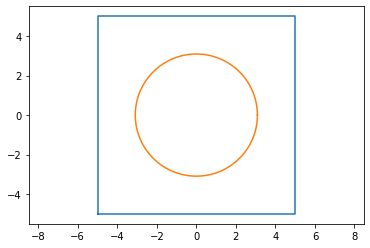

In [12]:
inclusion = Inclusion(0, None)
f = 0.3
microstructure = Microstructure(None, {inclusion:f})
print(microstructure)
microstructure.draw()